In [1]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
print("module imported")

module imported


Data Loading from kaggle

In [2]:
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


In [3]:
# Loading the dataset path
dataset_path = path

# Defining the training and testing directories
train_dir = os.path.join(dataset_path, "Combined Dataset/train")
test_dir = os.path.join(dataset_path, "Combined Dataset/test")

# Defining the updated categories (renaming "Very Mild Impairment" to "Alzheimer")
categories = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Alzheimer"]

# Optional: Renaming the folder in the filesystem (if the directory is named "Very Mild Impairment")
very_mild_impairment_dir = os.path.join(train_dir, "Very Mild Impairment")
alz_dir = os.path.join(train_dir, "Alzheimer")

# Renaming the directory (if it exists)
if os.path.exists(very_mild_impairment_dir):
    os.rename(very_mild_impairment_dir, alz_dir)

# Same for the test directory if needed
very_mild_impairment_test_dir = os.path.join(test_dir, "Very Mild Impairment")
alz_test_dir = os.path.join(test_dir, "Alzheimer")
if os.path.exists(very_mild_impairment_test_dir):
    os.rename(very_mild_impairment_test_dir, alz_test_dir)

In [4]:
# Loop through each category and load images
images = [] # Initialize images list
labels = [] # Initialize labels list
# Loop through each category and load images
for category in categories:
    category_dir = os.path.join(train_dir, category)
    for image_name in os.listdir(category_dir):
        image_path = os.path.join(category_dir, image_name)

        # Load the image and resize to the target size
        img = load_img(image_path, target_size=(150, 150))  # Resizing to 150x150
        img_array = img_to_array(img)  # Convert image to numpy array

        # Normalize pixel values to range [0, 1]
        img_array = img_array / 255.0

        images.append(img_array)
        labels.append(category)


In [5]:
# Convert the images and labels lists into NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels)


# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

# Convert to one-hot encoding
labels_one_hot = to_categorical(labels_encoded)

Data preprocessing and visualization

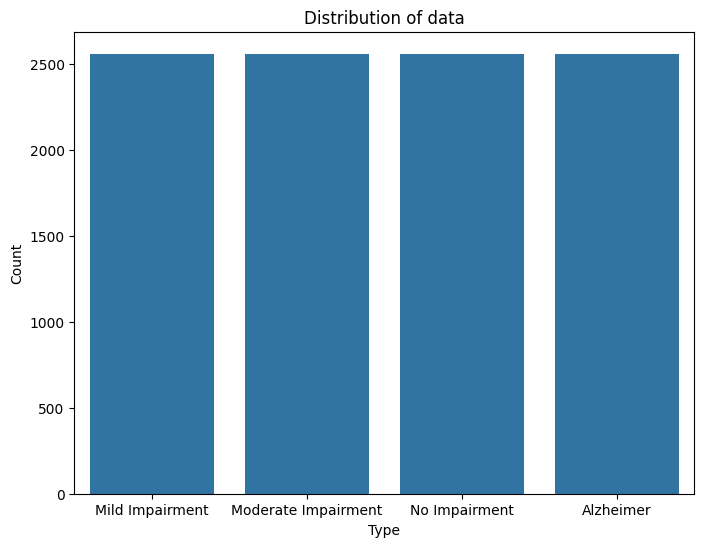

In [6]:
# Loading and preprocessing the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

# Concatenating the training data into a single DataFrame
train_df = pd.concat(train_data, ignore_index=True)

# Visualizing the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of data")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

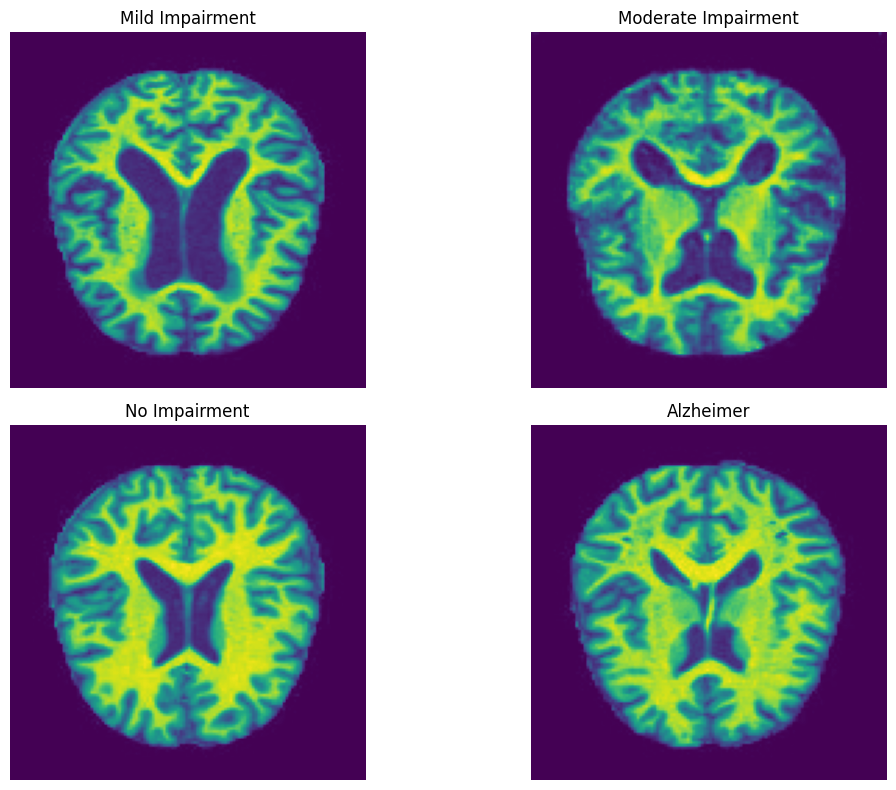

In [7]:
# Visualizing sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

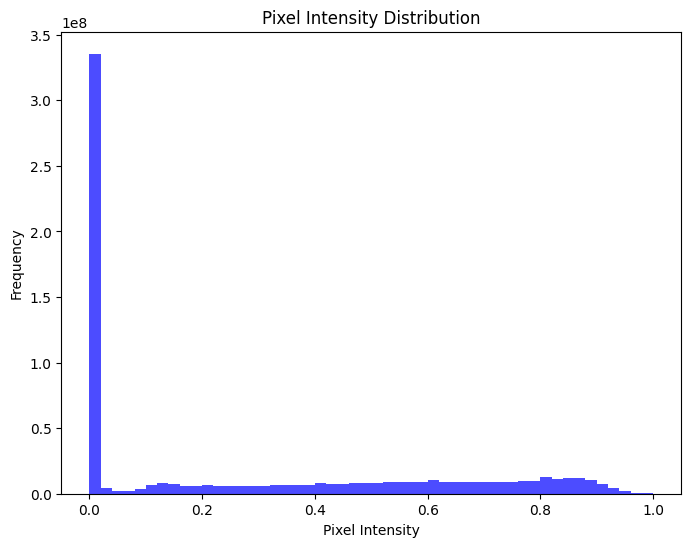

In [6]:
# Flatten the image array for intensity distribution
flat_pixel_values = images_array.flatten()

plt.figure(figsize=(8, 6))
plt.hist(flat_pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Define the image size and batch size
image_size = (150, 150)
batch_size = 32
epochs = 5

In [20]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


Model architecture and data splitting

In [10]:
# model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(images_array, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Model Training

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.3382 - loss: 1.2671 - val_accuracy: 0.7559 - val_loss: 0.5609
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.7584 - loss: 0.5524 - val_accuracy: 0.8268 - val_loss: 0.3898
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8420 - loss: 0.3778 - val_accuracy: 0.8659 - val_loss: 0.3041
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8801 - loss: 0.2808 - val_accuracy: 0.9154 - val_loss: 0.2199
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.9312 - loss: 0.1816 - val_accuracy: 0.9141 - val_loss: 0.2343


Classfication report and analysis

In [16]:
# Predict on the test set
y_pred_prob = model.predict(X_test)  # Outputs probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class labels

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=categories)
accuracy = accuracy_score(y_true, y_pred)

# Print the report
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step
Classification Report:
                     precision    recall  f1-score   support

    Mild Impairment       0.78      0.91      0.84       372
Moderate Impairment       0.99      0.85      0.91       390
      No Impairment       1.00      1.00      1.00       390
          Alzheimer       0.87      0.85      0.86       384

           accuracy                           0.90      1536
          macro avg       0.91      0.90      0.90      1536
       weighted avg       0.91      0.90      0.90      1536

Accuracy: 0.90


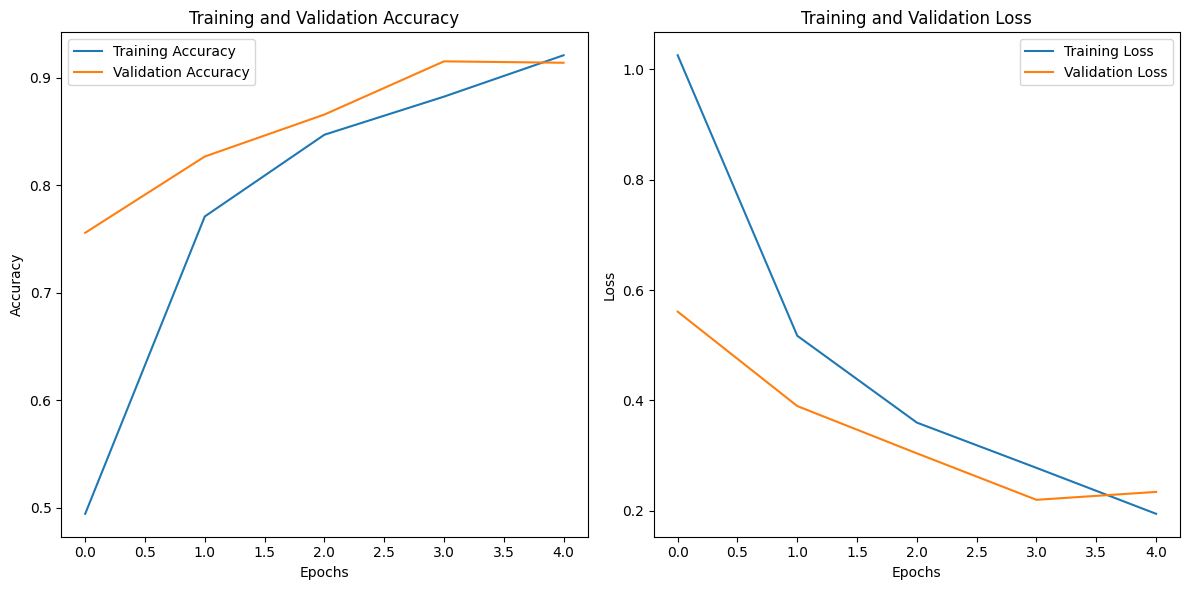

In [17]:
# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training and Validation Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

# Plot Training and Validation Loss
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

# Display the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step


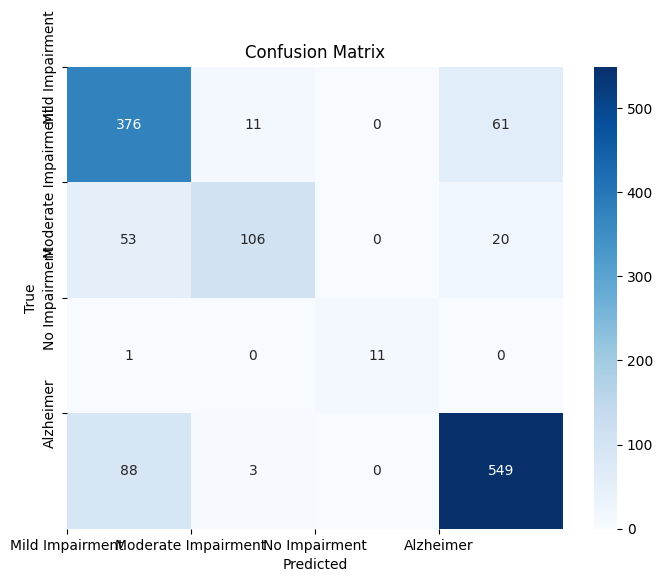

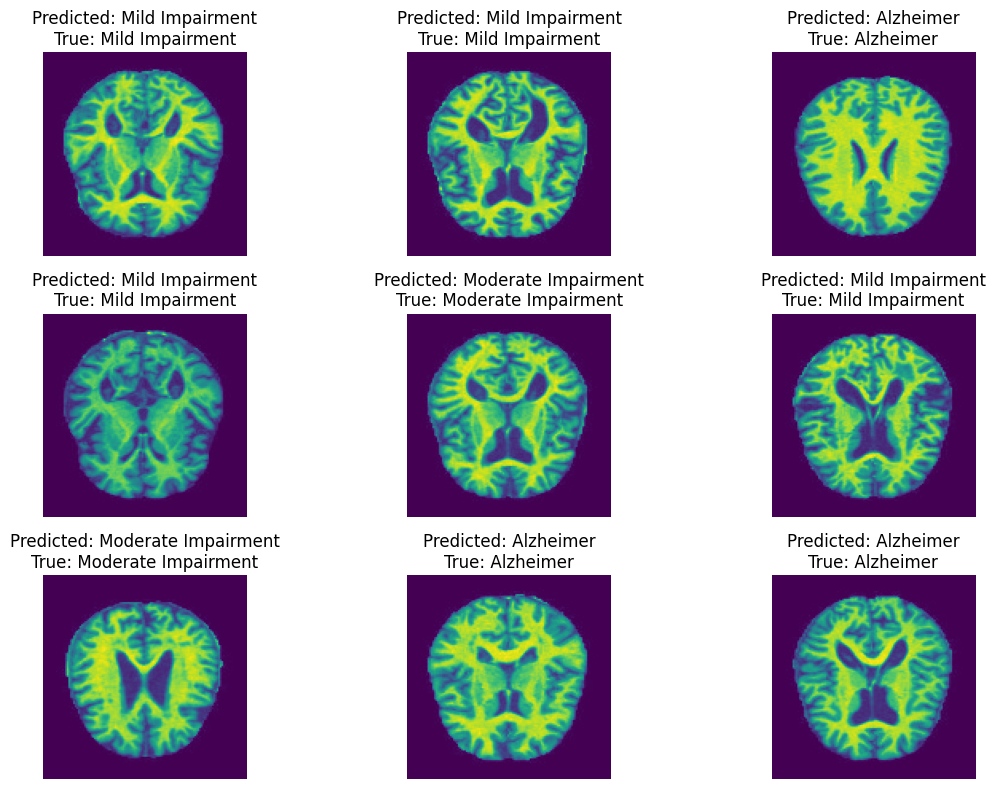

In [18]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: Mild Impairment
Precision: 0.7258687258687259
Recall: 0.8392857142857143
F1-Score: 0.7784679089026915

Class: Moderate Impairment
Precision: 0.8833333333333333
Recall: 0.5921787709497207
F1-Score: 0.7090301003344481

Class: No Impairment
Precision: 1.0
Recall: 0.9166666666666666
F1-Score: 0.9565217391304348

Class: Alzheimer
Precision: 0.8714285714285714
Recall: 0.8578125
F1-Score: 0.8645669291338582



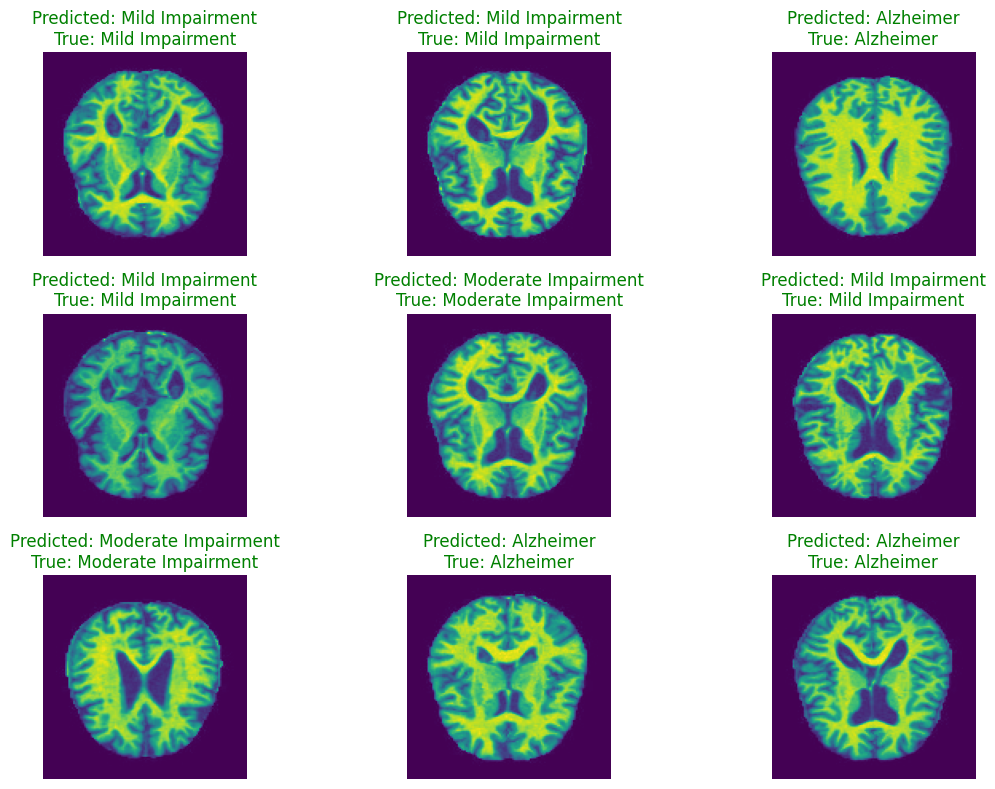

In [19]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
model.save("alzheimer_model.h5")